

```
# Article: https://arxiv.org/pdf/2108.03358
# Source Code (original authors): https://github.com/shuwang127/PatchRNN
# Demo Code (original authors): https://github.com/shuwang127/PatchRNN-demo
# Run Initialisation once, after starting a new Environment in Colab
# Initialisation requires 16 GB RAM and can take a few minutes.
```

# Initialisation



## Helpers

In [ ]:
#STARTIGNORE - helper functions
import os
import requests
from pathlib import Path

def CreateDirectory(path):
  if os.path.exists(path):
    return
  else:
    os.mkdir(path)

def CreateFile(path, content, binary = False):
  if binary == True:
    with open(path, "wb") as f:
      f.write(content)
  else:
    with open(path, "w") as f:
      f.write(content)

def ReadFile(path):
    with open(path, "r", errors="replace") as f:
      return f.read()

def Download(url, dest):
  # Download helper functions from Learn PyTorch repo (if not already downloaded)
  if Path(f"{dest}").is_file():
    print(f"{dest} already exists, skipping download")
  else:
    print(f"Downloading {dest}")
    request = requests.get(url)
    CreateFile(dest,request.content,True)

def GetJsonFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.json()

def GetTextFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.text

def ReleaseGPUMemory():
  import gc
  import torch
  for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()
    try:
      del model
    except:
      pass

def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned() else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned() else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)
#ENDIGNORE



```
# Run this once, after starting a new Environment
# https://github.com/shuwang127/PatchRNN
```

## Data Fetch

In [ ]:
# Get the numpy arrays from repository
!git clone https://github.com/shuwang127/PatchRNN
!mv PatchRNN/analysis .
!mv PatchRNN/data .
!mv PatchRNN/temp .
!rm -r PatchRNN
!unzip -d data/negatives/ data/negatives/20200401N.zip && rm data/negatives/20200401N.zip
!unzip -d data/negatives/ data/negatives/20200512N.zip && rm data/negatives/20200512N.zip
!unzip -d data/negatives/ data/negatives/20200528N.zip && rm data/negatives/20200528N.zip
!unzip -d data/negatives/ data/negatives/20200603N.zip && rm data/negatives/20200603N.zip
!unzip -d data/negatives/ data/negatives/20200618N.zip && rm data/negatives/20200618N.zip
!unzip -d data/negatives/ data/negatives/20200707N.zip && rm data/negatives/20200707N.zip
!unzip -d data/positives/ data/positives/20200401P.zip && rm data/positives/20200401P.zip
!unzip -d data/positives/ data/positives/20200512P.zip && rm data/positives/20200512P.zip
!unzip -d data/positives/ data/positives/20200528P.zip && rm data/positives/20200528P.zip
!unzip -d data/positives/ data/positives/20200603P.zip && rm data/positives/20200603P.zip
!unzip -d data/positives/ data/positives/20200618P.zip && rm data/positives/20200618P.zip
!unzip -d data/positives/ data/positives/20200707P.zip && rm data/positives/20200707P.zip
!unzip -d temp temp/data.zip && rm temp/data.zip
!unzip -d temp temp/msgs.zip && rm temp/msgs.zip
!unzip -d temp temp/props.zip && rm temp/props.zip

Cloning into 'PatchRNN'...
remote: Enumerating objects: 37054, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 37054 (delta 10), reused 9 (delta 9), pack-reused 37040 (from 1)
Receiving objects: 100% (37054/37054), 202.05 MiB | 4.82 MiB/s, done.
Resolving deltas: 100% (425/425), done.
mv: cannot move 'PatchRNN/analysis' to './analysis': Directory not empty
mv: cannot move 'PatchRNN/data' to './data': Directory not empty
mv: cannot move 'PatchRNN/temp' to './temp': Directory not empty
unzip:  cannot find or open data/negatives/20200401N.zip, data/negatives/20200401N.zip.zip or data/negatives/20200401N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200512N.zip, data/negatives/20200512N.zip.zip or data/negatives/20200512N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200528N.zip, data/negatives/20200528N.zip.zip or data/negatives/20200528N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200603N.zip, data

## Default Hyperparameters (global variables)



In [ ]:
# @title  {"display-mode":"code"}
# This section contains mostly unchanged code created by:
# Xinda Wang∗, Shu Wang∗, Pengbin Feng∗, Kun Sun∗, Sushil Jajodia∗, Sanae Benchaaboun†, and Frank Geck†∗Center for Secure Information Systems, George Mason University, Fairfax, VA, US† CSIA Division, C5ISR Center, Space and Terrestrial Communications Directorate,U.S. Army Combat Capabilities Development Command (DEVCOM)
# PatchRNN: A Deep Learning-Based System for Security Patch Identification
# Original code can be found here: https://github.com/shuwang127/PatchRNN-demo/tree/main/model
# Shared under Apache 2.0 license: https://github.com/shuwang127/PatchRNN-demo/tree/main?tab=Apache-2.0-1-ov-file#readme
# There might be minor changes that were necessary to port the original code to Transformer-based setup in later sections.

os.system('pip install clang')
import re
import gc
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import clang.cindex
import clang.enumerations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
from sklearn.metrics import accuracy_score

# environment settings.
_COLAB_ = 0 if (os.getenv('COLAB_GPU', 'NONE') == 'NONE') else 1 # 0 : Local environment, 1 : Google Colaboratory.
_COLAB_ = 0
# file paths.
rootPath = './drive/My Drive/Colab Notebooks/' if (_COLAB_) else './'
dataPath = rootPath + '/data/'
sDatPath = dataPath + '/security_patch/'
pDatPath = dataPath + '/positives/'
nDatPath = dataPath + '/negatives/'
tempPath = rootPath + '/temp/'

# hyper-parameters. (affect GPU memory size)
_DiffEmbedDim_  = 128       # 128
_DiffMaxLen_    = 600       # 200(0.7), 314(0.8), 609(0.9), 1100(0.95), 2200(0.98), 3289(0.99), 5000(0.995), 10000(0.9997)
_DRnnHidSiz_    = 16        # 16
_MsgEmbedDim_   = 128       # 128
_MsgMaxLen_     = 200       # 54(0.9), 78(0.95), 130(0.98), 187(0.99), 268(0.995), 356(0.998), 516(0.999), 1434(1)
_MRnnHidSiz_    = 32        # 16
_TwinEmbedDim_  = 128       # 128
_TwinMaxLen_    = 800       # 224(0.8), 425(0.9), 755(0.95), 1448(0.98), 2270(0.99)
_TRnnHidSiz_    = 32        # 16
# hyper-parameters. (affect training speed)
_DRnnBatchSz_   = 128       # 128
_DRnnLearnRt_   = 0.0001    # 0.0001
_MRnnBatchSz_   = 128       # 128
_MRnnLearnRt_   = 0.0001    # 0.0001
_PRnnBatchSz_   = 256       # 256
_PRnnLearnRt_   = 0.0005    # 0.0005
_TRnnBatchSz_   = 256       # 256
_TRnnLearnRt_   = 0.0005    # 0.0005
# hyper-parameters. (trivial network parameters, unnecessary to modify)
_DiffExtraDim_  = 2         # 2
_TwinExtraDim_  = 1         # 1
_DRnnHidLay_    = 1         # 1
_MRnnHidLay_    = 1         # 1
_TRnnHidLay_    = 1         # 1
# hyper-parameters. (epoch related parameters, unnecessary to modify)
_DRnnMaxEpoch_  = 1000      # 1000
_DRnnPerEpoch_  = 1         # 1
_DRnnJudEpoch_  = 10        # 10
_MRnnMaxEpoch_  = 1000      # 1000
_MRnnPerEpoch_  = 1         # 1
_MRnnJudEpoch_  = 10        # 10
_PRnnMaxEpoch_  = 1000      # 1000
_PRnnPerEpoch_  = 1         # 1
_PRnnJudEpoch_  = 10        # 10
_TRnnMaxEpoch_  = 1000      # 1000
_TRnnPerEpoch_  = 1         # 1
_TRnnJudEpoch_  = 10        # 10
# hyper-parameters. (flow control)
_DEBUG_ = 0 #  0 : release
            #  1 : debug
_LOCK_  = 0 #  0 : unlocked - create random split sets.
            #  1 : locked   - use the saved split sets.
_MODEL_ = 0 #  0 : unlocked - train a new model.
            #  1 : locked   - load the saved model.
_DTYP_  = 1 #  0 : maintain both diff code and context code.
            #  1 : only maintain diff code.
_CTYP_  = 0 #  0 : maintain both the code and comments.
            #  1 : only maintain code and delete comments.
_NIND_ =  1 # -1 : not abstract tokens. (and will disable _NLIT_)
            #  0 : abstract identifiers with VAR/FUNC.
            #  1 : abstract identifiers with VARn/FUNCn.
_NLIT_  = 1 #  0 : abstract literals with LITERAL.
            #  1 : abstract literals with LITERAL/n.
_TWIN_  = 1 #  0 : only twin neural network.
            #  1 : twins + msg neural network.

# print setting.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(threshold=np.inf)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Codebase from original article

In [ ]:
# Copied from shuwang127/PatchRNN-demo
# @title SplitData
def SplitData(data, labels, setType, rate=0.2):
    '''
    Split the data and labels into two sets with a specific rate.
    :param data: feature data.
    [[[n, {0~5}, {-1~1}], ...], ...]
    [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, {-1~1}], ...], ...]
    :param labels: labels. [[0/1], ...]
    :param setType: the splited dataset type.
    :param rate: the split rate. 0 ~ 1
    :return: dsetRest - the rest dataset.
             lsetRest - the rest labels.
             dset - the splited dataset.
             lset - the splited labels.
    '''

    # set parameters.
    setType = setType.upper()
    numData = len(data)
    num = math.floor(numData * rate)

    # get the random data list.
    if (os.path.exists(tempPath + '/split_' + setType + '.npy')) & (_LOCK_):
        dataList = np.load(tempPath + '/split_' + setType + '.npy')
    else:
        dataList = list(range(numData))
        random.seed(10)
        random.shuffle(dataList)
        np.save(tempPath + '/split_' + setType + '.npy', dataList, allow_pickle=True)

    # split data.
    dset = data[dataList[0:num]]
    lset = labels[dataList[0:num]]
    dsetRest = data[dataList[num:]]
    lsetRest = labels[dataList[num:]]

    # print.
    setTypeRest = 'TRAIN' if (setType == 'VALID') else 'REST'
    print('[INFO] <SplitData> Split data into ' + str(len(dsetRest)) + ' ' + setTypeRest
          + ' dataset and ' + str(len(dset)) + ' ' + setType + ' dataset. (Total: '
          + str(len(dsetRest) + len(dset)) + ', Rate: ' + str(int(rate * 100)) + '%)')

    return dsetRest, lsetRest, dset, lset

In [ ]:
# @title TwinRNNTrain
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model

In [ ]:
# @title ReadData
def ReadData():
    '''
    Read data from the files.
    :return: data - a set of commit message, diff code, and labels.
    [[['', ...], [['', ...], ['', ...], ...], 0/1], ...]
    '''

    def ReadCommitMsg(filename):
        '''
        Read commit message from a file.
        :param filename: file name (string).
        :return: commitMsg - commit message.
        ['line', 'line', ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        #numLines = len(lines)   # get the line number.
        #print(lines)

        # initialize commit message.
        commitMsg = []
        # get the wide range of commit message.
        for line in lines:
            if line.startswith('diff --git'):
                break
            else:
                commitMsg.append(line)
        #print(commitMsg)
        # process the head of commit message.
        while (1):
            headMsg = commitMsg[0]
            if (headMsg.startswith('From') or headMsg.startswith('Date:') or headMsg.startswith('Subject:')
                    or headMsg.startswith('commit') or headMsg.startswith('Author:')):
                commitMsg.pop(0)
            else:
                break
        #print(commitMsg)
        # process the tail of commit message.
        dashLines = [i for i in range(len(commitMsg))
                     if commitMsg[i].startswith('---')]  # finds all lines start with ---.
        if (len(dashLines)):
            lnum = dashLines[-1]  # last line number of ---
            marks = [1 if (' file changed, ' in commitMsg[i] or ' files changed, ' in commitMsg[i]) else 0
                     for i in range(lnum, len(commitMsg))]
            if (sum(marks)):
                for i in reversed(range(lnum, len(commitMsg))):
                    commitMsg.pop(i)
        #print(commitMsg)

        #msgShow = ''
        #for i in range(len(commitMsg)):
        #    msgShow += commitMsg[i]
        #print(msgShow)

        return commitMsg

    def ReadDiffLines(filename):
        '''
        Read diff code from a file.
        :param filename:  file name (string).
        :return: diffLines - diff code.
        [['line', ...], ['line', ...], ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        numLines = len(lines)  # get the line number.
        # print(filename)

        atLines = [i for i in range(numLines) if lines[i].startswith('@@ ')]  # find all lines start with @@.
        atLines.append(numLines)
        # print(atLines)

        diffLines = []
        for nh in range(len(atLines) - 1):  # find all hunks.
            # print(atLines[nh], atLines[nh + 1])
            hunk = []
            for nl in range(atLines[nh] + 1, atLines[nh + 1]):
                # print(lines[nl], end='')
                if lines[nl].startswith('diff --git '):
                    break
                else:
                    hunk.append(lines[nl])
            diffLines.append(hunk)
            # print(hunk)
        # print(diffLines)
        # print(len(diffLines))

        # process the last hunk.
        lastHunk = diffLines[-1]
        numLastHunk = len(lastHunk)
        dashLines = [i for i in range(numLastHunk) if lastHunk[i].startswith('--')]
        if (len(dashLines)):
            lnum = dashLines[-1]
            for i in reversed(range(lnum, numLastHunk)):
                lastHunk.pop(i)
        # print(diffLines)
        # print(len(diffLines))

        return diffLines

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'filelist.txt', 'w')

    # initialize data.
    data = []
    # read security patch data.
    for root, ds, fs in os.walk(sDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read positive data.
    for root, ds, fs in os.walk(pDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read negative data.
    for root, ds, fs in os.walk(nDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 0])
    fp.close()

    #print(len(dataLoaded))
    #print(len(dataLoaded[0]))
    #print(dataLoaded)
    # [[['a', 'b', 'c', ], [['', '', '', ], ['', '', '', ], ], 0/1], ]
    # sample = dataLoaded[i]
    # commitMsg = dataLoaded[i][0]
    # diffLines = dataLoaded[i][1]
    # label = dataLoaded[i][2]
    # diffHunk = dataLoaded[i][1][j]

    # save dataLoaded.
    if not os.path.exists(tempPath + '/data.npy'):
        np.save(tempPath + '/data.npy', data, allow_pickle=True)
        print('[INFO] <ReadData> Save ' + str(len(data)) + ' raw data to ' + tempPath + '/data.npy.')

    return data

In [ ]:
# @title GetDiffProps
def GetDiffProps(data):
    '''
    Get the properties of the code in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: props - [[[tokens], [nums], [nums], 0/1], ...]
    '''

    def RemoveSign(line):
        '''
        Remove the sign (+/-) in the first character.
        :param line: a code line.
        :return: process line.
        '''

        return ' ' + line[1:] if (line[0] == '+') or (line[0] == '-') else line

    def GetClangTokens(line):
        '''
        Get the tokens of a line with the Clang tool.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # remove non-ascii
        line = line.encode("ascii", "ignore").decode()

        # defination.
        tokenClass = [clang.cindex.TokenKind.KEYWORD,      # 1
                      clang.cindex.TokenKind.IDENTIFIER,   # 2
                      clang.cindex.TokenKind.LITERAL,      # 3
                      clang.cindex.TokenKind.PUNCTUATION,  # 4
                      clang.cindex.TokenKind.COMMENT]      # 5
        tokenDict = {cls: index + 1 for index, cls in enumerate(tokenClass)}
        #print(tokenDict)

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # clang sparser.
        idx = clang.cindex.Index.create()
        tu = idx.parse('tmp.cpp', args=['-std=c++11'], unsaved_files=[('tmp.cpp', RemoveSign(line))], options=0)
        for t in tu.get_tokens(extent=tu.cursor.extent):
            #print(t.kind, t.spelling, t.location)
            tokens.append(t.spelling)
            tokenTypes.append(tokenDict[t.kind])
            diffTypes.append(1 if (line[0] == '+') else -1 if (line[0] == '-') else 0)
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    def GetWordTokens(line):
        '''
        Get the word tokens from a code line.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
        '''

        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(RemoveSign(line))
        return tokens

    def GetString(lines):
        '''
        Get the strings from the diff code
        :param lines: diff code.
        :return: lineStr - All the diff lines.
                 lineStrB - The before-version code lines.
                 lineStrA - The after-version code lines.
        '''

        lineStr = ''
        lineStrB = ''
        lineStrA = ''
        for hunk in lines:
            for line in hunk:
                # all lines.
                lineStr += RemoveSign(line)
                # all Before lines.
                lineStrB += RemoveSign(line) if line[0] != '+' else ''
                # all After lines.
                lineStrA += RemoveSign(line) if line[0] != '-' else ''

        return lineStr, lineStrB, lineStrA

    def GetDiffTokens(lines):
        '''
        Get the tokens for the diff lines.
        :param lines: the diff code.
        :return: tokens - tokens ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - token types [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - diff types [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # for each line of lines.
        for hunk in lines:
            for line in hunk:
                #print(line, end='')
                tk, tkT, dfT = GetClangTokens(line)
                tokens.extend(tk)
                tokenTypes.extend(tkT)
                diffTypes.extend(dfT)
                #print('-----------------------------------------------------------------------')
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    #lines = data[0][1]
    #print(lines)
    #hunk = data[0][1][0]
    #print(hunk)
    #line = data[0][1][0][0]
    #print(line)

    # for each sample data[n].
    numData = len(data)
    props = []
    for n in range(numData):
        # get the lines of the diff file.
        diffLines = data[n][1]
        # properties.
        tk, tkT, dfT = GetDiffTokens(diffLines)
        label = data[n][2]
        prop = [tk, tkT, dfT, label]
        #print(prop)
        props.append(prop)
        print(n)

    # save props.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/props.npy'):
        np.save(tempPath + '/props.npy', props, allow_pickle=True)
        print('[INFO] <GetDiffProps> Save ' + str(len(props)) + ' diff property data to ' + tempPath + '/props.npy.')

    return props

In [ ]:
# @title ProcessTokens
def ProcessTokens(props, dType=1, cType=1):
    '''
    only maintain the diff parts of the code.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param dType: 0 - maintain both diff code and context code.
                  1 - only maintain diff code.
    :param cType: 0 - maintain both the code and comments.
                  1 - only maintain code and delete comments.
    :return: props - the normalized features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    # process diff code.
    if (1 == dType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[2][n])]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[2][n])]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[2][n])]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Only maintain the diff parts of the code.')

    # process comments.
    if (1 == cType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[1][n] < 5)]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[1][n] < 5)]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[1][n] < 5)]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Delete the comment parts of the diff code.')

    #print(props[0])

    return props

In [ ]:
# @title AbstractTokens
def AbstractTokens(props, iType=1, lType=1):
    '''
    abstract the tokens of identifiers, literals, and comments.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param iType:   -1 - not abstract tokens.
                     0 - only abstract variable type and function type. VAR / FUNC
                     1 - abstract the identical variable names and function names.  VAR0, VAR1, ... / FUNC0, FUNC1, ...
    :param lType:   -1 - not abstract tokens.
                     0 - abstract literals with LITERAL.
                     1 - abstract literals with LITERAL/n.
    :return: props - the abstracted features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    if (iType not in [0, 1]) or (lType not in [0, 1]):
        print('[INFO] <AbstractTokens> Not abstract the tokens of identifiers, literals, and comments.')
        return props

    for item in props:
        # get tokens and token types.
        tokens = item[0]
        tokenTypes = item[1]
        numTokens = len(tokenTypes)
        #print(tokens)
        #print(tokenTypes)
        #print(numTokens)

        # abstract literals and comments, and separate identifiers into variables and functions.
        markVar = list(np.zeros(numTokens, dtype=int))
        markFuc = list(np.zeros(numTokens, dtype=int))
        for n in range(numTokens):
            # 2: IDENTIFIER, 3: LITERAL, 5: COMMENT
            if 5 == tokenTypes[n]:
                tokens[n] = 'COMMENT'
            elif 3 == tokenTypes[n]:
                if (0 == lType):
                    tokens[n] = 'LITERAL'
                elif (1 == lType):
                    if (not tokens[n].isdigit()):
                        tokens[n] = 'LITERAL'
            elif 2 == tokenTypes[n]:
                # separate variable name and function name.
                if (n < numTokens-1):
                    if (tokens[n+1] == '('):
                        markFuc[n] = 1
                    else:
                        markVar[n] = 1
                else:
                    markVar[n] = 1
        #print(tokens)
        #print(markVar)
        #print(markFuc)

        # abstract variables and functions.
        if (0 == iType):
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = 'VAR'
                elif 1 == markFuc[n]:
                    tokens[n] = 'FUNC'
        elif (1 == iType):
            # get variable dictionary.
            varList = [tokens[idx] for idx, mark in enumerate(markVar) if mark == 1]
            varVoc  = {}.fromkeys(varList)
            varVoc  = list(varVoc.keys())
            varDict = {tk: 'VAR' + str(idx) for idx, tk in enumerate(varVoc)}
            # get function dictionary.
            fucList = [tokens[idx] for idx, mark in enumerate(markFuc) if mark == 1]
            fucVoc  = {}.fromkeys(fucList)
            fucVoc  = list(fucVoc.keys())
            fucDict = {tk: 'FUNC' + str(idx) for idx, tk in enumerate(fucVoc)}
            #print(varDict)
            #print(fucDict)
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = varDict[tokens[n]]
                elif 1 == markFuc[n]:
                    tokens[n] = fucDict[tokens[n]]
    #print(tokens)
    print('[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType ' + str(iType), end='')
    print(' (VAR/FUNC).') if (0 == iType) else print(' (VARn/FUNCn).')
    print('[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType ' + str(lType), end='')
    print(' (LITERAL/COMMENT).') if (0 == lType) else print(' (LITERAL/n/COMMENT).')

    return props

In [ ]:
# @title GetDiffVocab
def GetDiffVocab(props):
    '''
    Get the vocabulary of diff tokens
    :param props - the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :return: vocab - the vocabulary of diff tokens. ['tk', 'tk', ...]
             maxLen - the max length of a diff code.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'difflen.csv', 'w')

    # get the whole tokens and the max diff length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in props:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetDiffVocab> There are ' + str(len(vocab)) + ' diff vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetDiffVocab> The max diff length is ' + str(maxLen) + ' tokens. (hyperparameter: _DiffMaxLen_ = ' + str(_DiffMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetDiffDict
def GetDiffDict(vocab):
    '''
    Get the dictionary of diff vocabulary.
    :param vocab: the vocabulary of diff tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetDiffDict> Create dictionary for ' + str(len(tokenDict)) + ' diff vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetDiffEmbed
def GetDiffEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of diff vocabulary.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetDiffEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/preWeights.npy'):
        np.save(tempPath + '/preWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetDiffEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/preWeights.npy.')

    return preWeights

In [ ]:
# @title DivideBeforeAfter
def DivideBeforeAfter(diffProps):

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'twinlen.csv', 'w')

    twinProps = []
    maxLen = 0
    # for each sample in diffProps.
    for item in diffProps:
        # get the tk, tkT, dfT, lb.
        tokens = item[0]
        tokenTypes = item[1]
        diffTypes = item[2]
        label = item[3]
        numTokens = len(diffTypes)
        # reconstruct tkB, tkTB, tkA, tkTA.
        tokensB = [tokens[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokenTypesB = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokensA = [tokens[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        tokenTypesA = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        # reconstruct new sample.
        sample = [tokensB, tokenTypesB, tokensA, tokenTypesA, label]
        twinProps.append(sample)
        # get max length.
        maxLenAB = max(len(tokenTypesB), len(tokenTypesA))
        maxLen = maxLenAB if (maxLen < maxLenAB) else maxLen
        fp.write(str(len(tokenTypesB)) + '\n')
        fp.write(str(len(tokenTypesA)) + '\n')
    fp.close()

    #print(twinProps[0])
    #print(maxLen)

    # print.
    print('[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.')
    print('[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is ' + str(maxLen) + ' tokens. (hyperparameter: _TwinMaxLen_ = ' + str(_TwinMaxLen_) + ')')

    return twinProps, maxLen

In [ ]:
# @title GetTwinMapping
def GetTwinMapping(props, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of diff code.
    [[[tokens], [nums], [tokens], [nums], 0/1], ...]
    :param maxLen: the max length of a twin code.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[[n, {0~5}, n, {0~5}], ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in props:
        # initialize sample.
        sample = []

        # process tokensB.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesB.
        tokenTypes = item[1]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)
        # process tokensA.
        tokens = item[2]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesA.
        tokenTypes = item[3]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)

        # process sample.
        sample = np.array(sample).T
        data.append(sample)
        # process label.
        label = item[4]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetTwinMapping> Create ' + str(len(data)) + ' feature data with ' + str(len(data[0])) + ' * ' + str(len(data[0][0])) + ' matrix.')
    print('[INFO] <GetTwinMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/tdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/tlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/tdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy data to ' + tempPath + '/tdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/tlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy labels to ' + tempPath + '/tlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title UpdateTwinTokenTypes
def UpdateTwinTokenTypes(data):
    '''
    Update the token type in the feature data into one-hot vector.
    :param data: feature data. [[[n, {0~5}, n, {0~5},], ...], ...]
    :return: np.array(newData). [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    '''

    newData = []
    # for each sample.
    for item in data:
        # get the transpose of props.
        itemT = item.T
        # initialize new sample.
        newItem = []
        newItem.append(itemT[0])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        newItem.append(itemT[2])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        # assign the new sample.
        for i in range(len(item)):
            tokenType = itemT[1][i]
            if (tokenType):
                newItem[tokenType][i] = 1
            tokenType = itemT[3][i]
            if (tokenType):
                newItem[tokenType+6][i] = 1
        # get the transpose of new sample.
        newItem = np.array(newItem).T
        # append new sample.
        newData.append(newItem)

    if _DEBUG_:
        print('[DEBUG] newData:')
        print(newData[0:3])

    # print.
    print('[INFO] <UpdateTwinTokenTypes> Update ' + str(len(newData)) + ' feature data with ' + str(len(newData[0])) + ' * ' + str(len(newData[0][0])) + ' matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy')):
        np.save(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy', newData, allow_pickle=True)
        print('[INFO] <UpdateTwinTokenTypes> Save the mapped numpy data to ' + tempPath + '/newtdata_' + str(len(newData[0])) + '.npy.')

    # change marco.
    global _TwinExtraDim_
    _TwinExtraDim_ = 5

    return np.array(newData)

In [ ]:
# @title GetCommitMsgs
def GetCommitMsgs(data):
    '''
    Get the commit messages in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: msgs - [[[tokens], 0/1], ...]
    '''

    def GetMsgTokens(lines):
        '''
        Get the tokens from a commit message.
        :param lines: commit message. [line, , ]
        :return: tokensStem ['tk', , ]
        '''

        # concatenate lines.
        # get the string of commit message.
        msg = ''
        for line in lines:
            msg += line[:-1] + ' '
        #print(msg)

        # pre-process.
        # remove url.
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        msg = re.sub(pattern, ' ', msg)
        # remove independent numbers.
        pattern = r' \d+ '
        msg = re.sub(pattern, ' ', msg)
        # lower case capitalized words.
        pattern = r'([A-Z][a-z]+)'
        def LowerFunc(matched):
            return matched.group(1).lower()
        msg = re.sub(pattern, LowerFunc, msg)
        # remove footnote.
        patterns = ['signed-off-by:', 'reported-by:', 'reviewed-by:', 'acked-by:', 'found-by:', 'tested-by:', 'cc:']
        for pattern in patterns:
            index = msg.find(pattern)
            if (index > 0):
                msg = msg[:index]
        #print(msg)

        # clearance.
        # get the tokens.
        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(msg)
        # clear tokens that don't contain any english letter.
        for i in reversed(range(len(tokens))):
            if not (re.search('[a-z]', tokens[i])):
                tokens.pop(i)
        # clear tokens that are stopwords.
        for i in reversed(range(len(tokens))):
            if (tokens[i] in stopwords.words('english')):
                tokens.pop(i)
        pattern = re.compile("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
        for i in reversed(range(len(tokens))):
            if (pattern.findall(tokens[i])):
                tokens.pop(i)
        #print(tokens)

        # process tokens with stemming.
        porter = PorterStemmer()
        tokensStem = []
        for item in tokens:
            tokensStem.append(porter.stem(item))
        #print(tokensStem)

        return tokensStem

    # for each sample data[n].
    numData = len(data)
    msgs = []
    for n in range(numData):
        # get the lines of the commit message.
        commitMsg = data[n][0]
        mtk = GetMsgTokens(commitMsg)
        # get the label.
        label = data[n][2]
        #print([mtk, label])
        # append the message tokens.
        msgs.append([mtk, label])
        print(n)

    # save commit messages.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/msgs.npy'):
        np.save(tempPath + '/msgs.npy', msgs, allow_pickle=True)
        print('[INFO] <GetCommitMsg> Save ' + str(len(msgs)) + ' commit messages to ' + tempPath + '/msgs.npy.')

    return msgs

In [ ]:
# @title GetMsgVocab
def GetMsgVocab(msgs):
    '''
    Get the vocabulary of message tokens
    :param msgs - [[[tokens], 0/1], ...]
    :return: vocab - the vocabulary of message tokens. ['tk', 'tk', ...]
             maxLen - the max length of a commit message.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'msglen.csv', 'w')

    # get the whole tokens and the max msg length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in msgs:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetMsgVocab> There are ' + str(len(vocab)) + ' commit message vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetMsgVocab> The max msg length is ' + str(maxLen) + ' tokens. (hyperparameter: _MsgMaxLen_ = ' + str(_MsgMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetMsgDict
def GetMsgDict(vocab):
    '''
    Get the dictionary of msg vocabulary.
    :param vocab: the vocabulary of msg tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of msg vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetMsgDict> Create dictionary for ' + str(len(tokenDict)) + ' msg vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetMsgEmbed
def GetMsgEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of msg vocabulary.
    :param tokenDict: the dictionary of msg vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetMsgEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/msgPreWeights.npy'):
        np.save(tempPath + '/msgPreWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetMsgEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/msgPreWeights.npy.')

    return preWeights

In [ ]:
# @title GetMsgMapping
def GetMsgMapping(msgs, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of commit messages.
    [[[tokens], 0/1], ...]
    :param maxLen: the max length of the commit message.
    :param tokenDict: the dictionary of commit message vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[n, ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in msgs:
        # process tokens.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        # convert tokens into numbers.
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        data.append(tokens2index)
        # process label.
        label = item[1]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetMsgMapping> Create ' + str(len(data)) + ' feature data with 1 * ' + str(len(data[0])) + ' vector.')
    print('[INFO] <GetMsgMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/mdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/mlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/mdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy data to ' + tempPath + '/mdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/mlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy labels to ' + tempPath + '/mlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title CombineTwinMsgs
def CombineTwinMsgs(props, msgs, plabels, mlabels):
    '''
    Combine the twin props with the commit messages.
    :param props: twin data. [[[n, {0~5}, n, {0~5}], ...], ...] or [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    :param msgs: message data. [[n, ...], ...]
    :param plabels: twin labels. [[0/1], ...]
    :param mlabels: message labels. [[0/1], ...]
    :return: np.array(data) - combined data. [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1, n], ...], ...]
             np.array(plabels) - combined labels. [[0/1], ...]
    '''

    # check the lengths.
    if (len(plabels) != len(mlabels)):
        print('[ERROR] <CombineTwinMsgs> the data lengths are mismatch.')
        return [[]], [[]]

    # check the labels.
    cntMatch = 0
    for n in range(len(plabels)):
        if (plabels[n][0] == mlabels[n][0]):
            cntMatch += 1
    if (cntMatch != len(plabels)):
        print('[ERROR] <CombineTwinMsgs> the labels are mismatch. ' + str(cntMatch) + '/' + str(len(plabels)) + '.')
        return [[]], [[]]

    #print(props[1], len(props[1]))
    #print(msgs[1], len(msgs[1]))

    data = []
    for n in range(len(plabels)):
        # get the twin prop and message.
        prop = props[n]
        msg = msgs[n]
        # pad data.
        if (_TwinMaxLen_ >= _MsgMaxLen_):
            msg = np.pad(msg, (0, _TwinMaxLen_ - _MsgMaxLen_), 'constant')
        else:
            prop = np.pad(prop, ((0, _MsgMaxLen_ - _TwinMaxLen_), (0, 0)), 'constant')
        #print(msg, len(msg))
        #print(prop, len(prop))
        # reconstruct sample.
        sample = np.vstack((prop.T, msg))
        # append the sample to data.
        data.append(sample.T)

    if _DEBUG_:
        print(np.array(data[0:3]))

    print('[INFO] <CombineTwinMsgs> Combine the twin props with the commit messages.')

    return np.array(data), np.array(plabels)

In [ ]:
# @title OutputEval
def OutputEval(predictions, labels, method=''):
    '''
    Output the evaluation results.
    :param predictions: predicted labels. [[0], [1], ...]
    :param labels: ground truth labels. [[1], [1], ...]
    :param method: method name. string
    :return: accuracy - the total accuracy. numeric
             confusion - confusion matrix [[1000, 23], [12, 500]]
    '''

    # evaluate the predictions with gold labels, and get accuracy and confusion matrix.
    def Evaluation(predictions, labels):

        # parameter settings.
        D = len(labels)
        cls = 2

        # get confusion matrix.
        confusion = np.zeros((cls, cls))
        for ind in range(D):
            nRow = int(predictions[ind][0])
            nCol = int(labels[ind][0])
            confusion[nRow][nCol] += 1

        # get accuracy.
        accuracy = 0
        for ind in range(cls):
            accuracy += confusion[ind][ind]
        accuracy /= D

        return accuracy, confusion

    # get accuracy and confusion matrix.
    accuracy, confusion = Evaluation(predictions, labels)
    precision = confusion[1][1] / (confusion[1][0] + confusion[1][1]) if (confusion[1][0] + confusion[1][1]) else 0
    recall = confusion[1][1] / (confusion[0][1] + confusion[1][1]) if (confusion[0][1] + confusion[1][1]) else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # output on screen and to file.
    print('       -------------------------------------------')
    print('       method           :  ' +  method) if len(method) else print('', end='')
    print('       accuracy  (ACC)  :  %.3f%%' % (accuracy * 100))
    print('       precision (P)    :  %.3f%%' % (precision * 100))
    print('       recall    (R)    :  %.3f%%' % (recall * 100))
    print('       F1 score  (F1)   :  %.3f' % (F1))
    print('       fall-out  (FPR)  :  %.3f%%' % (confusion[1][0] * 100 / (confusion[1][0] + confusion[0][0])))
    print('       miss rate (FNR)  :  %.3f%%' % (confusion[0][1] * 100 / (confusion[0][1] + confusion[1][1])))
    print('       confusion matrix :      (actual)')
    print('                           Neg         Pos')
    print('       (predicted) Neg     %-5d(TN)   %-5d(FN)' % (confusion[0][0], confusion[0][1]))
    print('                   Pos     %-5d(FP)   %-5d(TP)' % (confusion[1][0], confusion[1][1]))
    print('       -------------------------------------------')

    return accuracy, confusion

## Loading data to memory

In [ ]:
# load data.
if (not os.path.exists(tempPath + '/data.npy')):  # | (not _DEBUG_)
    dataLoaded = ReadData()
else:
    dataLoaded = np.load(tempPath + '/data.npy', allow_pickle=True)
    print('[INFO] <ReadData> Load ' + str(len(dataLoaded)) + ' raw data from ' + tempPath + '/data.npy.')

# get the diff file properties.
if (not os.path.exists(tempPath + '/props.npy')):
    diffProps = GetDiffProps(dataLoaded)
else:
    diffProps = np.load(tempPath + '/props.npy', allow_pickle=True)
    print('[INFO] <GetDiffProps> Load ' + str(len(diffProps)) + ' diff property data from ' + tempPath + '/props.npy.')
# maintain both the context and diff parts. Delete comments.
diffProps = ProcessTokens(diffProps, dType=0, cType=_CTYP_)
# normalize the tokens of identifiers (VARn/FUNCn), literals (LITERAL/n), and comments (none).
diffProps = AbstractTokens(diffProps, iType=_NIND_, lType=_NLIT_)
# get the diff token vocabulary.
diffVocab, _ = GetDiffVocab(diffProps)
# TS: Noting exceptional up to this point. :TS
# get the diff token dictionary.
diffDict = GetDiffDict(diffVocab)
# TS:
# diffDict contains encodings based on the input code. It's not extensible for new keyword tokens at this point. E.g  while is encoded as 1
# List of standard key-value pairs where k:str and v:int
# :TS
# get pre-trained weights for embedding layer.
twinPreWeights = GetDiffEmbed(diffDict, _TwinEmbedDim_)
# divide diff code into before/after-version code.
twinProps, twinMaxLen = DivideBeforeAfter(diffProps)
# TS: At this point twinProps are in the following format
# every item in twinProps is a list of 4 items
# [[beforestr1,...,beforestrN] , [beforestrType1,...,beforestrType1] , [afterstr1,...,afterstrN] , [afterstrType1,...,afterstrTypeN]]
# where beforestr1 can be e.g while and thus beforestrType1 will be 1 (1 == keyword)
# :TS
# get the max twin length.
twinMaxLen = _TwinMaxLen_ if (twinMaxLen > _DiffMaxLen_) else twinMaxLen
# get the mapping for feature data and labels.
twinData, twinLabels = GetTwinMapping(twinProps, twinMaxLen, diffDict)
# TS:
# At this point every item in twinData is a 2-d array:
# [[encodedtoken0B, encodedtokenType0B, encodedtoken0A, encodedTokenType0A], ..., [encodedtokenNB, encodedtokenTypeNB, encodedtokenNA, encodedTokenTypeNA]
# The lenghts are 'padded'
# :TS
# change the tokentypes into one-hot vector.
twinData = UpdateTwinTokenTypes(twinData)
# TS: Note that this encodes only token-types, the tokenID remains an integer value, which is fine, because then we have embeddings:
# e.g: [[ 1  1  0  0  0  0  1  1  0  0  0  0],
# [ 2  0  0  0  1  0  2  0  0  0  1  0],
# [ 3  0  0  0  1  0  3  0  0  0  1  0]....
# Each row is [tokenB 5x tokenTypeB.onehot tokenA 5x tokenTypeA.onehot]
# get the commit messages from data.
if (not os.path.exists(tempPath + '/msgs.npy')):
    commitMsgs = GetCommitMsgs(dataLoaded)
else:
    commitMsgs = np.load(tempPath + '/msgs.npy', allow_pickle=True)
    print('[INFO] <GetCommitMsg> Load ' + str(len(commitMsgs)) + ' commit messages from ' + tempPath + '/msgs.npy.')
# TS: Loaded messages are only key words + label, they are no longer structured like a normal message.
# e.g: [list(['dv', 'fix', 'null', 'pointer', 'derefer', 'due', 'ach', 'fix', 'part']) 1]
# :TS
# get the message token vocabulary.
msgVocab, msgMaxLen = GetMsgVocab(commitMsgs)
# get the max msg length.
msgMaxLen = _MsgMaxLen_ if (msgMaxLen > _MsgMaxLen_) else msgMaxLen
# get the msg token dictionary.
# TS: Every token found in messages is converted to dict (it's not just words, they are detected in more elaborate fashion, for example word 'architecture' becomes 'architectur')
# :TS
msgDict = GetMsgDict(msgVocab)
# TS: Straightforward "token" to "int"
# :TS
# get pre-trained weights for embedding layer.
msgPreWeights = GetMsgEmbed(msgDict, _MsgEmbedDim_)
# get the mapping for feature data and labels.
msgData, msgLabels = GetMsgMapping(commitMsgs, msgMaxLen, msgDict)
# TS:
# msgData items are just lists of tokens. (padded and not one-hot encoded, which is fine, because then we we have embeddings)
# [ 1  2  3  4  5  6  7  8  3  4  9 10 11 12 13 14 15  3  4  0  0  0 ... padding .... 0]
# :TS
# combine the twin data with the message data.
data, label = CombineTwinMsgs(twinData, msgData, twinLabels, msgLabels)
# TS:
# Every data item is the following:
#[[ 4  0  1  0  0  0  4  0  1  0  0  0  1]
# [21  0  0  0  1  0 21  0  0  0  1  0  2]
# ....
# [[tokenB, 5x one-hotTypeB, tokenA, 5x one-hotTypeA, msgToken]....
# Last column is simply message tokens encoded
# :TS

[INFO] <ReadData> Load 38041 raw data from .//temp//data.npy.
[INFO] <GetDiffProps> Load 38041 diff property data from .//temp//props.npy.
[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType 1 (VARn/FUNCn).
[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType 1 (LITERAL/n/COMMENT).
[INFO] <GetDiffVocab> There are 35575 diff vocabulary tokens. (except '<pad>')
[INFO] <GetDiffVocab> The max diff length is 2706522 tokens. (hyperparameter: _DiffMaxLen_ = 600)
[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
[INFO] <GetDiffEmbed> Create pre-trained embedding weights with 35576 * 128 matrix.
[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.
[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is 1938015 tokens. (hyperparameter: _TwinMaxLen_ = 800)
[INFO] <GetTwinMapping> Create 38041 feature data with 800 * 4 matrix.
[INFO] <GetTwinMapping> Create 38041

# Network Training - LSTM (original)

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 500
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 1
_TTransformerBatchSz_ = 64
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800

In [ ]:
# @title class TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())
        return self.softmax(final_out)      # batch_size * class_num

### Test/Train Definitions

In [ ]:
# @title TwinRNN Train Definition
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model


In [ ]:
# @title Test TwinRNN Definition
def TwinRNNTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().cuda()
    yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy

## Run

In [ ]:
# @title RunRNN
def RunRNN():
  # TwinRNNTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinRNN.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
  else:
      model = TwinRNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinRNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinRNN')

In [ ]:
# This code runs default setup by original authors of the article (with hyperparameter changes)
# The result is that we can easily achieve 82% accuracy on test dataset in <10 epochs.
# [Epoch 010] loss: 0.399, train acc: 91.910%, valid acc: 83.899%, test acc: 83.899%.
# This model uses: 1. Code before, 2. Code after, 3. Commit Messages to
RunRNN()

[INFO] <TwinRNNTrain> ModelType: TwinRNN.
[INFO] <TwinRNNTrain> Code Part: EmbedDim: 128, MaxLen: 800, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: 128, MaxLen: 200, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> BatchSize: 256, LearningRate: 0.0005, MaxEpoch: 1000, PerEpoch: 1, JudEpoch: 10.


KeyboardInterrupt: 

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore Error 'model' is not defined


torch.cuda.empty_cache()
gc.collect()
# !nvidia-smi # Prints nvidia stats

del model

NameError: name 'model' is not defined

# Dataprep (both DS / BERT)


In [ ]:
#@title Switch depending on deepseek or bert
from transformers import AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
#tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-V2-Lite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip install datasets

  Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (42.1 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 19.0.1 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 19.0.1 which is incompatible.


In [ ]:
!pip install pyarrow==14.0.2

  Using cached pyarrow-14.0.2-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-14.0.2-cp310-cp310-manylinux_2_28_x86_64.whl (38.0 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.2 which is incompatible.


In [ ]:
from datasets import Dataset


In [ ]:
# @title SplitData
def SplitDataRaw(data, rate=0.2):
    numData = len(data)
    num = math.floor(numData * rate)

    dataList = list(range(numData))
    random.seed(10)
    random.shuffle(dataList)


    # split data.
    dset = data[dataList[0:num]]
    dsetRest = data[dataList[num:]]

    return dset,dsetRest

In [ ]:
dataLSTest,dataLSTrain = SplitDataRaw(dataLoaded)

In [ ]:
dsTrainR = Dataset.from_dict({
    "commit": dataLSTrain[:, 0],
    "code": dataLSTrain[:, 1],
    "label": dataLSTrain[:, 2]
})

dsTestR = Dataset.from_dict({
    "commit": dataLSTest[:, 0],
    "code": dataLSTest[:, 1],
    "label": dataLSTest[:, 2]
})

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Deepseek

In [ ]:
import torch
import torch.nn.functional as F


device = "cpu"

In [ ]:
!pip install flash_attn

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel
from transformers.models.llama.modeling_llama import LlamaModel  # DeepSeek is LLaMA-based
import torch.nn as nn

class DeepseekForSequenceClassification(PreTrainedModel):
    def __init__(self, config, num_labels=2):
        super().__init__(config)
        self.model = AutoModel.from_config(config)  # Load base model from config
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, -1]  # Take last token for classification
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# Load DeepSeek config
config = AutoConfig.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", trust_remote_code=True)

# Inject number of labels (if not already in config)
config.num_labels = 2

# Create model
model = DeepseekForSequenceClassification(config)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", trust_remote_code=True)

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
def join_and_tokenize(sample):
  joined_text = f"COMMIT: {sample['commit']} CODE: {sample['code']}"
  sample['text'] = joined_text
  return tokenizer(
        sample["text"],
        padding="max_length",
        truncation=True,
        max_length=800
    )

In [ ]:
dsTrain = dsTrainR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])
dsTest = dsTestR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])

TypeError: Dataset.map() got an unexpected keyword argument 'streaming'

In [ ]:
model

DeepseekForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
   

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    np.savetxt("reals.txt", labels, fmt="%s", delimiter="\n")
    np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")
    # Calculate F1 score
    f1 = f1_score(labels, predictions, average='weighted')  # Use 'weighted' for multiclass; change as needed for binary

    metrics = {
        'accuracy': accuracy,
        'f1_score': f1
    }

    return metrics

# TrainingArguments setup
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    report_to="none",
    eval_strategy="steps",
    eval_steps=100,
    no_cuda=True,
    use_cpu=True
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [ ]:
from datasets import IterableDataset
from transformers import Trainer, TrainingArguments

# Function to handle tokenization and data processing
def join_and_tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")

# Custom IterableDataset class
class StreamableDataset(IterableDataset):
    def __init__(self, dataset, processing_fn=None, epochs=1, length=None):
        self.dataset = dataset
        self.processing_fn = processing_fn
        self.epochs = epochs  # Number of epochs to iterate over
        self._epoch = 0  # Initialize epoch tracker
        self.length = length  # Approximate length of the dataset, can be provided
        self._iterator = iter(self.dataset)  # Initialize the iterator for the dataset

    def __iter__(self):
        # Iterate over the dataset for a specific number of epochs
        for _ in range(self.epochs):
            for example in self.dataset:
                # Apply processing function lazily
                if self.processing_fn:
                    yield self.processing_fn(example)
                else:
                    yield example

    # Manually implement the `_epoch` method expected by the Trainer
    def set_epoch(self, epoch):
        """Set the epoch number, this method is expected by the Trainer"""
        self._epoch = epoch

    def __len__(self):
        """Return the length of the dataset.
        If `length` is provided, return it, otherwise, return a default value or an approximation."""
        if self.length is not None:
            return self.length  # Use the provided length if available
        else:
            raise ValueError("StreamableDataset requires a length or an approximation for len()")

    def __getitem__(self, idx):
        """Implement the __getitem__ method for indexing support"""
        # This is tricky because IterableDataset does not support random access, but we can create an iterator
        if idx < 0 or idx >= self.length:
            raise IndexError("Index out of range")
        # Reinitialize the iterator if it is exhausted, and move to the idx-th element
        self._iterator = iter(self.dataset)
        for i, example in enumerate(self._iterator):
            if i == idx:
                if self.processing_fn:
                    return self.processing_fn(example)
                return example
        raise IndexError("Index out of range")

# Convert dsTrain and dsTest to streamable datasets
streamable_dsTrain = StreamableDataset(dsTrainR, processing_fn=join_and_tokenize, epochs=1, length=len(dsTrain))
streamable_dsTest = StreamableDataset(dsTestR, processing_fn=join_and_tokenize, epochs=1, length=len(dsTest))

batch_size = 32  # replace with your batch size
train_size = len(dsTrain)  # This will still work since `dsTrain` is iterable
steps_per_epoch = train_size // batch_size

# If you want to run for a specific number of epochs
num_epochs = 1  # Set to the number of epochs you want to train for
max_steps = num_epochs * steps_per_epoch

# Create the TrainingArguments and specify max_steps
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    max_steps=max_steps,  # Use max_steps instead of num_train_epochs
    weight_decay=0.01,
    report_to="none",
    eval_strategy="steps",
    eval_steps=100,
    no_cuda=True,  # Ensure it uses the CPU (if you want to enforce it)
    use_cpu=True,  # Ensure it uses the CPU
)

# Trainer setup using streamable datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=streamable_dsTrain,
    eval_dataset=streamable_dsTest,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dsTrain,
    eval_dataset=dsTest,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Add compute_metrics here
)

import warnings
warnings.filterwarnings("ignore", message="Can't initialize NVML")


# Start training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,No log,0.455696,0.789695,0.783159
200,No log,0.403056,0.827944,0.820086
300,No log,0.424573,0.820978,0.802209
400,No log,0.352494,0.855547,0.848766


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [ ]:
model

NameError: name 'model' is not defined

# Pretrained bert

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
def join_and_tokenize(sample):
  joined_text = f"COMMIT: {sample['commit']} CODE: {sample['code']}"
  sample['text'] = joined_text
  return tokenizer(
        sample["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

In [ ]:
dsTrain = dsTrainR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])
dsTest = dsTestR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])

Map:   0%|          | 0/30433 [00:00<?, ? examples/s]

Map:   0%|          | 0/7608 [00:00<?, ? examples/s]

In [ ]:
import torch

device = "cpu"

In [ ]:
# import torch
# from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# def preprocess_function(example):
#   encoded_example =  tokenizer(example['text'], truncation=True)
#   # example['input_ids'] = encoded_example['input_ids']
#   # example['attention_mask'] = encoded_example['attention_mask']
#   return encoded_example

In [ ]:
# ds_dataset = ds.map(preprocess_function, batched=True, batch_size=64)

Map:   0%|          | 0/38041 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#df_dataset_split = ds_dataset.train_test_split(test_size=0.1)

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 19.0.1 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 19.0.1 which is incompatible.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    np.savetxt("reals.txt", labels, fmt="%s", delimiter="\n")
    np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")
    # Calculate F1 score
    f1 = f1_score(labels, predictions, average='weighted')  # Use 'weighted' for multiclass; change as needed for binary

    metrics = {
        'accuracy': accuracy,
        'f1_score': f1
    }

    return metrics

# TrainingArguments setup
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    report_to="none",
    eval_strategy="steps",
    eval_steps=100,
    use_cpu=True
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dsTrain,
    eval_dataset=dsTest,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Add compute_metrics here
)

# Start training
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,No log,0.440882,0.797581,0.785000
200,No log,0.294921,0.878812,0.876854
300,No log,0.274253,0.890510,0.890020
400,No log,0.271847,0.895636,0.893091
500,0.363000,0.275881,0.893139,0.893446
600,0.363000,0.250598,0.897871,0.897459
700,0.363000,0.239236,0.902340,0.901306
800,0.363000,0.245184,0.898922,0.898906
900,0.363000,0.246024,0.898791,0.898966


TrainOutput(global_step=952, training_loss=0.30656792937206623, metrics={'train_runtime': 68453.991, 'train_samples_per_second': 0.445, 'train_steps_per_second': 0.014, 'total_flos': 8007258747770880.0, 'train_loss': 0.30656792937206623, 'epoch': 1.0})

In [ ]:
model

In [ ]:
# @title OutputEval
def OutputEval(predictions, labels, method=''):
    '''
    Output the evaluation results.
    :param predictions: predicted labels. [[0], [1], ...]
    :param labels: ground truth labels. [[1], [1], ...]
    :param method: method name. string
    :return: accuracy - the total accuracy. numeric
             confusion - confusion matrix [[1000, 23], [12, 500]]
    '''

    # evaluate the predictions with gold labels, and get accuracy and confusion matrix.
    def Evaluation(predictions, labels):

        # parameter settings.
        D = len(labels)
        cls = 2

        # get confusion matrix.
        confusion = np.zeros((cls, cls))
        for ind in range(D):
            nRow = int(predictions[ind][0])
            nCol = int(labels[ind][0])
            confusion[nRow][nCol] += 1

        # get accuracy.
        accuracy = 0
        for ind in range(cls):
            accuracy += confusion[ind][ind]
        accuracy /= D

        return accuracy, confusion

    # get accuracy and confusion matrix.
    accuracy, confusion = Evaluation(predictions, labels)
    precision = confusion[1][1] / (confusion[1][0] + confusion[1][1]) if (confusion[1][0] + confusion[1][1]) else 0
    recall = confusion[1][1] / (confusion[0][1] + confusion[1][1]) if (confusion[0][1] + confusion[1][1]) else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # output on screen and to file.
    print('       -------------------------------------------')
    print('       method           :  ' +  method) if len(method) else print('', end='')
    print('       accuracy  (ACC)  :  %.3f%%' % (accuracy * 100))
    print('       precision (P)    :  %.3f%%' % (precision * 100))
    print('       recall    (R)    :  %.3f%%' % (recall * 100))
    print('       F1 score  (F1)   :  %.3f' % (F1))
    print('       fall-out  (FPR)  :  %.3f%%' % (confusion[1][0] * 100 / (confusion[1][0] + confusion[0][0])))
    print('       miss rate (FNR)  :  %.3f%%' % (confusion[0][1] * 100 / (confusion[0][1] + confusion[1][1])))
    print('       confusion matrix :      (actual)')
    print('                           Neg         Pos')
    print('       (predicted) Neg     %-5d(TN)   %-5d(FN)' % (confusion[0][0], confusion[0][1]))
    print('                   Pos     %-5d(FP)   %-5d(TP)' % (confusion[1][0], confusion[1][1]))
    print('       -------------------------------------------')

    return accuracy, confusion

In [ ]:
reals = np.loadtxt("reals.txt").reshape(-1,1)
preds = np.loadtxt("predicted.txt").reshape(-1,1)

OutputEval(preds,reals)

       -------------------------------------------
       accuracy  (ACC)  :  89.879%
       precision (P)    :  84.041%
       recall    (R)    :  85.191%
       F1 score  (F1)   :  0.846
       fall-out  (FPR)  :  7.847%
       miss rate (FNR)  :  14.809%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4721 (TN)   368  (FN)
                   Pos     402  (FP)   2117 (TP)
       -------------------------------------------


(0.8987907465825447,
 array([[4721.,  368.],
        [ 402., 2117.]]))

In [ ]:
import time

start = time.perf_counter()  # Start time
test_preds = trainer.predict(dsTest)
end = time.perf_counter()  # End time
execution_time = (end - start)

print(f"Execution time: {execution_time:.3f} s")


In [ ]:
test_ds["test"].shape

(1, 6)

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
s = summary(model, input_size=(1, 6), dtypes=[torch.long])
print(s,model)  # Adjust input size to match model

Layer (type:depth-idx)                                       Output Shape              Param #
RobertaForSequenceClassification                             [1, 2]                    --
├─RobertaModel: 1-1                                          [1, 6, 768]               --
│    └─RobertaEmbeddings: 2-1                                [1, 6, 768]               --
│    │    └─Embedding: 3-1                                   [1, 6, 768]               38,603,520
│    │    └─Embedding: 3-2                                   [1, 6, 768]               768
│    │    └─Embedding: 3-3                                   [1, 6, 768]               394,752
│    │    └─LayerNorm: 3-4                                   [1, 6, 768]               1,536
│    │    └─Dropout: 3-5                                     [1, 6, 768]               --
│    └─RobertaEncoder: 2-2                                   [1, 6, 768]               --
│    │    └─ModuleList: 3-6                                  --               

In [ ]:
# Define save path
save_directory = "RobertaTrainedModel"

# Save the model
trainer.model.save_pretrained(save_directory)

# Save the tokenizer (important for reloading)
tokenizer.save_pretrained(save_directory)


('RobertaTrainedModel/tokenizer_config.json',
 'RobertaTrainedModel/special_tokens_map.json',
 'RobertaTrainedModel/vocab.json',
 'RobertaTrainedModel/merges.txt',
 'RobertaTrainedModel/added_tokens.json')

In [ ]:
# Load model and tokenizer from saved directory
model = RobertaForSequenceClassification.from_pretrained("RobertaTrainedModel")
tokenizer = RobertaTokenizer.from_pretrained("RobertaTrainedModel")

# Now you can use the model for predictions

In [ ]:
precision_metric = evaluate.load("f1")
results = precision_metric.compute(references=torch.tensor([0.0, 1.0]),
                                  predictions=torch.tensor([0.0, 1.0]))
print(results)

NameError: name 'evaluate' is not defined

In [ ]:
predictions = [0, 2, 1, 0, 0, 1]
references = [0, 1, 2, 0, 1, 2]
results = precision_metric.compute(predictions=predictions, references=references, average='macro')


# Network Training - Transformer Proposal

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 34237 REST dataset and 3804 TEST dataset. (Total: 38041, Rate: 10%)
[INFO] <demoTwin> Get 34237 TRAIN data, 3804 TEST data. (Total: 38041)


In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 20
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 5
_TTransformerBatchSz_ = 20
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800 # This parameter determines maximum sequence lenght

_nHead_ = 8
# Device
device = 'cpu'

In [ ]:
# @title TwinTransformer (nn.model)
class TwinTransformer(nn.Module):
    '''
    TwinTransformer : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinTransformer, self).__init__()
        # parameters.
        class_num = 2
        # twin.
        #vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True

        self.embedPositionTwin  = nn.Parameter(data=torch.randn(1, _TwinMaxLen_, emDimTwin),requires_grad=True)
        self.embedPositionMsg  = nn.Parameter(data=torch.randn(1, _MsgMaxLen_, emDimMsg),requires_grad=True)

        #vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True

        #lerneable parameters
        self.embedClassB = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassA = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassM = nn.Parameter(data=torch.randn(1, 1, emDimMsg),requires_grad=True)

        self.transformerTwinB = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.transformerTwinA = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=None, enable_nested_tensor=True, mask_check=False)

        self.transformerMsg = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimMsg,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=emDimTwin+emDimTwin+emDimMsg,
                      out_features=emDimTwin+emDimTwin+emDimMsg),
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Linear(in_features= emDimTwin+emDimTwin+emDimMsg,
                      out_features=class_num)
        )

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''
        batch_size = x.shape[0]
    # twin 1.
        #print("begin")
        xTwinB = x[:, :_TwinMaxLen_-1, :6]
        embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) # b,799,128
        featuresB = xTwinB[:, :, 1:] # b,799,5
        classTokenB = self.embedClassB.expand(batch_size,-1,-1).to(device)
        xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
        xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
        xb = self.embedPositionTwin + xb
        xb = self.transformerTwinB(xb) # b,800,128

    # twin 2.
        xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
        embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) # b,799,128
        featuresA = xTwinA[:, :, 1:] # b,799,5
        classTokenA = self.embedClassA.expand(batch_size,-1,-1).to(device)
        xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
        xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
        xa = self.embedPositionTwin + xa
        xa = self.transformerTwinA(xa) # b,800,128

    # msg.
        xMsg = x[:, :_MsgMaxLen_-1, -1]
        embedsMsg = self.embedMsg(xMsg) # b,199,128
        classTokenM = self.embedClassM.expand(batch_size,-1,-1).to(device)
        xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
        xm = self.embedPositionMsg + xm
        xm = self.transformerMsg(xm) # b,200,128

    # common.
        concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0]), dim=1) # b,128+128+128

        x = self.classifier(concatenated)
        return x

### Test/Train

In [ ]:
import time
# @title TwinTransformerTrain Definition
def TwinTransformerTrain(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)
    model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    model.to(device)
    print('[INFO] <TwinTransformer> ModelType: TwinTransformer.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []
    execution_times = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 100 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat)
            #print("Label",label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinTransformer.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinTransformer model. (Best model: ' + tempPath + '/model_TwinTransformer.pth)')

    return model, accList, execution_times, accL, validAccL, lossL

In [ ]:
# @title TwinTransformerTest Definition
def TwinTransformerTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

## Run

In [ ]:
# @title RunTransformer

def RunTransformer():
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinTransformer.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinTransformer(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
      return model
  else:
      model, acc,execution_times,accL, validAccL, lossL = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return model, acc,execution_times,accL, validAccL, lossL

In [ ]:
# @title RunTransformerFromFile
def RunTransformerFromFile():
  # TwinTransformerTrain
  #preWTwin = torch.from_numpy(twinPreWeights)
  #preWMsg = torch.from_numpy(msgPreWeights)
  model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
  return model
  model,acc = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=None, preWMsg=None,batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return acc

In [ ]:
#preWTwin = torch.from_numpy(twinPreWeights)
#print(preWTwin)
#print(type(twinPreWeights))
#twinPreWeights.shape
model,_,execution_times,accL, validAccL, lossL=RunTransformer()
#print(torch.from_numpy(msgPreWeights).size())
#acclst=RunTransformerFromFile()
#model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
#model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
#predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
#_, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

[INFO] <TwinTransformer> ModelType: TwinTransformer.


In [ ]:
print("TrainLoss")
for i in lossL:
  print(i)
print("Accuracy")
for i in accL:
  print(i)
print("ValidationAccuracy")
for i in validAccL:
  print(i)

TrainLoss
0.6836903764916263
0.5756226209647523
0.5202310553697183
0.4846651273868169
0.46042444149592765
0.4300165000826266
0.40777710488920066
0.3920866292165109
0.37296869444503095
0.35574744187351365
0.3367733137949913
0.3214805730009941
0.3035258052278548
0.2894542025524653
0.2729290025587007
0.2654637241017426
0.2519384859180981
Accuracy
59.69565090399276
71.75862371118966
76.54876303414436
78.4472938633642
79.5396792943307
81.12276192423401
82.0457399889009
83.10599643660368
83.97347898472412
84.72120804977071
85.62958203113591
86.37146946286181
87.3178140608114
87.84648187633263
88.57960685807753
89.06446242369367
89.60189268919589
ValidationAccuracy
68.21766561514195
74.65825446898002
76.76130389064143
79.41640378548895
80.57308096740273
80.5993690851735
79.57413249211356
80.09989484752892
80.3627760252366
79.57413249211356
81.12513144058885
80.5205047318612
80.73080967402734
81.38801261829653
80.31019978969506
80.5205047318612
80.28391167192429


In [ ]:
predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
_, confusion = OutputEval(predictions, labelTest, 'TwinTransformer')
np.savetxt("reals.txt", labelTest, fmt="%s", delimiter="\n")
np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")

Execution Time = 40.32994986139238 seconds
       -------------------------------------------
       method           :  TwinTransformer
       accuracy  (ACC)  :  81.388%
       precision (P)    :  69.203%
       recall    (R)    :  77.554%
       F1 score  (F1)   :  0.731
       fall-out  (FPR)  :  16.751%
       miss rate (FNR)  :  22.446%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     2132 (TN)   279  (FN)
                   Pos     429  (FP)   964  (TP)
       -------------------------------------------


In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
xTrain = torch.from_numpy(dataTrain).to(device)
yTrain = torch.from_numpy(labelTrain).to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=_TRnnBatchSz_, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

model_stats = summary(model, input_data=b1,batch_dim=0, verbose=1,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"], depth=100)

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)
print(model)

Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [189, 2]                  128,384                   --
├─Embedding: 1-1                              --                        [189, 799, 128]           4,553,728                 860,654,592
├─TransformerEncoder: 1-2                     --                        [189, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [189, 800, 128]           198,272                   --
│    └─LayerNorm: 2-2                         --                        [189, 800, 128]           256                       48,384
├─Embedding: 1-3                              --                        [189, 799, 128]    

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.MultiheadAttention):
        print(f"Layer: {name}, Number of Heads: {module.num_heads}")

Layer: transformerTwinB.layers.0.self_attn, Number of Heads: 2
Layer: transformerTwinA.layers.0.self_attn, Number of Heads: 2
Layer: transformerMsg.layers.0.self_attn, Number of Heads: 2


In [ ]:
model = RunTransformerFromFile()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-101-7b822e4054f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

In [ ]:
xTrain = torch.from_numpy(dataTrain).long().to(device)
yTrain = torch.from_numpy(labelTrain).long().to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=256, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

torch.Size([189, 800, 13])

In [ ]:
model_stats = summary(model, input_data=b1,batch_dim=0, verbose=0,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)

torch.Size([189, 800, 128])
Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [189, 2]                  128,384                   --
├─Embedding: 1-1                              --                        [189, 799, 128]           4,553,728                 860,654,592
├─TransformerEncoder: 1-2                     --                        [189, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [189, 800, 128]           198,272                   24,990,336
│    └─LayerNorm: 2-2                         --                        [189, 800, 128]           256                       48,384
├─Embedding: 1-3                              --       

In [ ]:
f = open("/persistent/article/models/1.txt", "w")
f.write(summary_str)
f.close()

[0.7033533508519889]


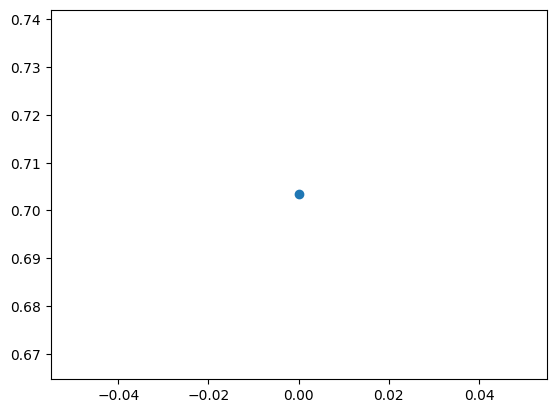

In [ ]:
import matplotlib.pyplot as plt
print(loss)
plt.plot(list(range(1)), loss[1:],linestyle="",marker="o")


In [ ]:
accs20241028 = acclst

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore error 'model' is not defined

torch.cuda.empty_cache()
gc.collect()
#!nvidia-smi #prints out stats

del model

## Result Analysis

In [ ]:
# @title TwinTransformerGetBadResults Definition
def TwinTransformerGetBadResults(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=1, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    falsePositives = []
    falseNegatives = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            if preds[0].int() != label.int():
              if preds[0].int() == 1:
                falsePositives.append(data)
              if preds[0].int() == 0:
                falseNegatives.append(data)

            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy, falsePositives, falseNegatives

In [ ]:
model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))



<ipython-input-49-a8faf42b97f2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


<All keys matched successfully>

In [ ]:
p,a,fp,fn = TwinTransformerGetBadResults(model,dataTest,labelTest)

In [ ]:
_, confusion = OutputEval(p, labelTest, 'TwinTwinTransformer')

       -------------------------------------------
       method           :  TwinTwinTransformer
       accuracy  (ACC)  :  83.333%
       precision (P)    :  76.322%
       recall    (R)    :  70.037%
       F1 score  (F1)   :  0.730
       fall-out  (FPR)  :  10.339%
       miss rate (FNR)  :  29.963%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4622 (TN)   735  (FN)
                   Pos     533  (FP)   1718 (TP)
       -------------------------------------------


In [ ]:
fdata = np.concatenate((fp,fn)).squeeze()
flabels = np.concatenate((np.zeros((len(fp),1)),np.ones((len(fn),1))))
fdata.shape

(1268, 800, 13)

In [ ]:
  modelV, acc = TwinTransformerTrain(fdata, flabels, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  acclst = acc
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformerV')

[INFO] <TwinTransformer> ModelType: TwinTransformer.
[Epoch 001] loss: 3.32, train acc: 28.391%, valid acc: 67.758%, test acc: 67.758%.
[Epoch 002] loss: 0.324, train acc: 91.719%, valid acc: 32.242%, test acc: 32.242%.


KeyboardInterrupt: 

In [ ]:
def TransformPatch2Imgs(sequence): #sequence 800x5
  bf = sequence[:,0:5]
  b = np.zeros((800,5))
  for i in range(len(bf)):
    itemValue = bf[i][0]
    itemChannel = np.argmax(bf[i][1:6])
    b[i][itemChannel] = itemValue
  b = b.reshape((20,40,5))
  af = sequence[:,6:]
  a = np.zeros((800,5))
  for i in range(len(af)):
    itemValue = af[i][0]
    itemChannel = np.argmax(af[i][1:6])
    a[i][itemChannel] = itemValue
  a = a.reshape((20,40,5))

  c = np.zeros((40,40,5))
  iter = 0
  for i in range(0,20):
    c[iter]=b[i]
    c[iter+1]=a[i]
    iter = iter +2

  return b,a,c #20x40x5 #h,w,c


In [ ]:
before, after, concatenated = TransformPatch2Imgs(fp[0])